In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.distributions import normal

import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# libraries from bliss 
from bliss.models import encoder
from bliss.datasets import sdss

# utils unique to this experiment
import sys
sys.path.insert(0, './utils')

from encoder_lib import MLPEncoder
from dataset_lib import CenteredStarsData, trim_psf
from which_device import device


print(device)


cuda:4


# Create dataset

### The psf

In [2]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

In [3]:
sdss_psf = sdss.SdssPSF(psf_file, [2])
psf = sdss_psf.psf_at_points(0, 0., 0.)

# convert to torch tensor
psf = torch.Tensor(psf).to(device)

# trim the psf
slen = 11
psf = trim_psf(psf, slen)

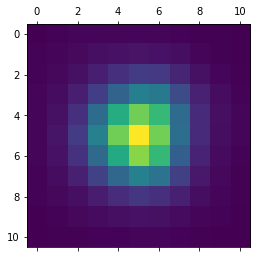

In [4]:
%matplotlib inline

plt.matshow(psf.cpu().numpy())

### the dataset: just centered stars

In [5]:
n_images = 20000
star_data = CenteredStarsData(psf, 
                              n_images = n_images)

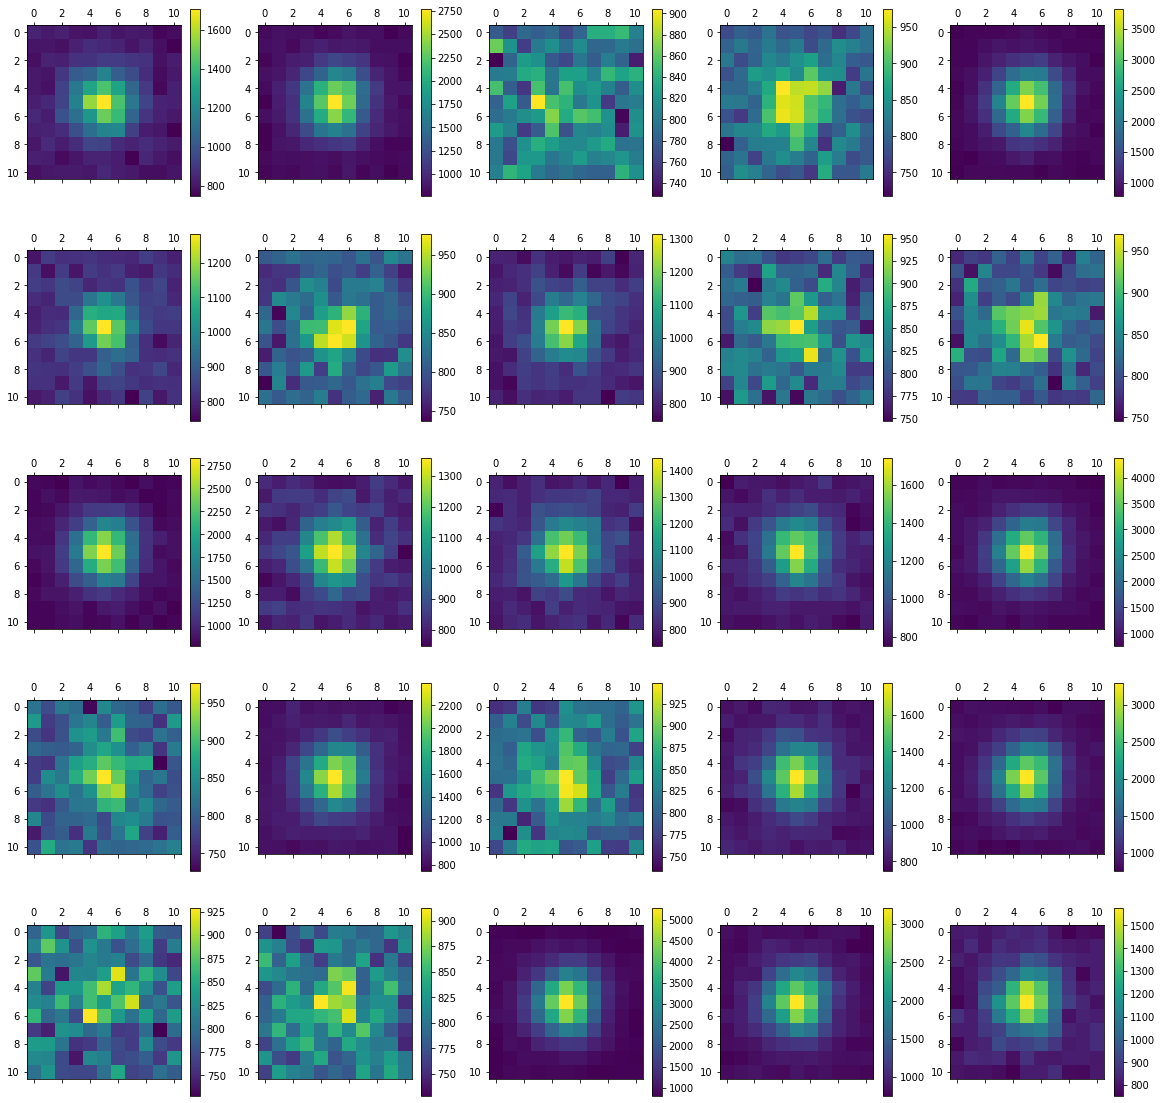

In [6]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25): 
        
    x0 = i // 5
    x1 = i % 5
    
    image = star_data[i]['image']
    
    im = ax[x0, x1].matshow(image[0].cpu())
    
    fig.colorbar(im, ax = ax[x0, x1])


# Define neural network

In [7]:
network = MLPEncoder(slen = slen).to(device)
network

MLPEncoder(
  (fc1): Linear(in_features=121, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

# Define dataset

In [8]:
batch_size = 64
train_data = DataLoader(star_data, 
                         batch_size=batch_size)


test_data = DataLoader(star_data, 
                       batch_size=n_images)

# Define loss

### Sleep phase loss: KL(p, q), with log-normal distribution

In [21]:
def klpq_logspace(network, batch): 
    
    images = batch['image']
    fluxes = batch['flux'].squeeze()
        
    mean, sd = network(images)
        
    norm = normal.Normal(loc = mean, scale = sd)
    
    return - norm.log_prob(fluxes)

# Train 

In [11]:
for _, test_batch in enumerate(test_data):
    break

In [12]:
# initial loss 
loss = klpq_logspace(network, test_batch).mean()
print('initial loss: {}'.format(loss))

initial loss: 30694.20703125


In [13]:
optimizer = optim.Adam(network.parameters(), 
                       lr = 1e-3)

In [14]:
n_epochs = 30

In [15]:
network.train()
t0 = time.time() 

for epoch in range(n_epochs): 
    
    avg_loss = 0.
    
    for _, batch in enumerate(train_data):
        
        optimizer.zero_grad()
        
        loss = klpq_logspace(network, batch).mean()
        loss.backward()
        
        optimizer.step()

        avg_loss += loss 
        
    print('epoch [{}]. loss = {}'.format(epoch, avg_loss / len(train_data)))

print('done. Elapsed {:.03f}sec'.format(time.time() - t0))

epoch [0]. loss = 482.7062683105469
epoch [1]. loss = 38.418006896972656
epoch [2]. loss = 35.57674026489258
epoch [3]. loss = 36.17658233642578
epoch [4]. loss = 35.12273025512695
epoch [5]. loss = 28.33833885192871
epoch [6]. loss = 34.227909088134766
epoch [7]. loss = 22.271530151367188
epoch [8]. loss = 35.479740142822266
epoch [9]. loss = 17.260652542114258
epoch [10]. loss = 19.921358108520508
epoch [11]. loss = 14.44802474975586
epoch [12]. loss = 11.670984268188477
epoch [13]. loss = 11.677155494689941
epoch [14]. loss = 10.819928169250488
epoch [15]. loss = 10.304044723510742
epoch [16]. loss = 8.921627044677734
epoch [17]. loss = 6.228680610656738
epoch [18]. loss = 12.628959655761719
epoch [19]. loss = 5.131681442260742
epoch [20]. loss = 5.574084281921387
epoch [21]. loss = 3.4778904914855957
epoch [22]. loss = 6.6316657066345215
epoch [23]. loss = 4.681142330169678
epoch [24]. loss = 5.125475883483887
epoch [25]. loss = 3.5268421173095703
epoch [26]. loss = 2.5541729927062

# check results

In [16]:
# final loss
network.eval()
loss = klpq_logspace(network, test_batch).mean()
print('final loss: {}'.format(loss))

final loss: 0.3547622561454773


In [17]:
true_fluxes = test_batch['flux']

means, sd = network(test_batch['image'])

Text(0, 0.5, 'true')

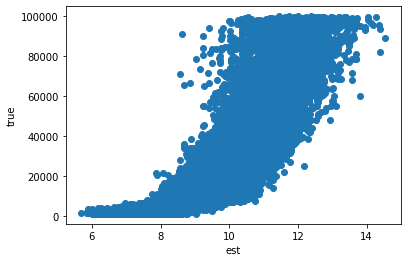

In [18]:
plt.scatter(means.detach().cpu(), 
            true_fluxes.cpu())

plt.xlabel('est')
plt.ylabel('true')

### Plot some residuals

In [19]:
def reconstruct_image(flux): 
    return star_data.psf * flux + star_data.background

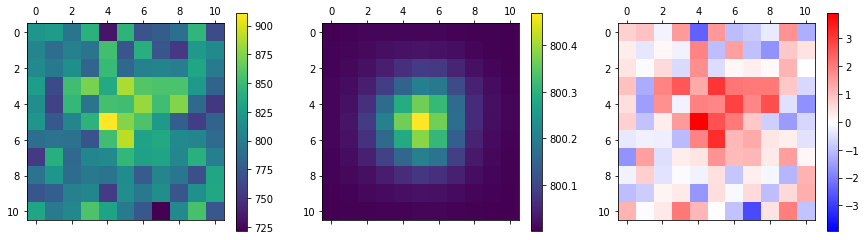

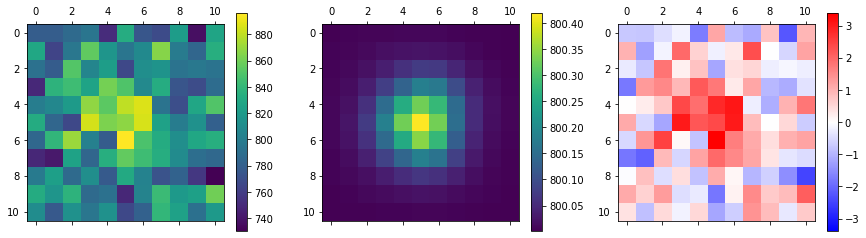

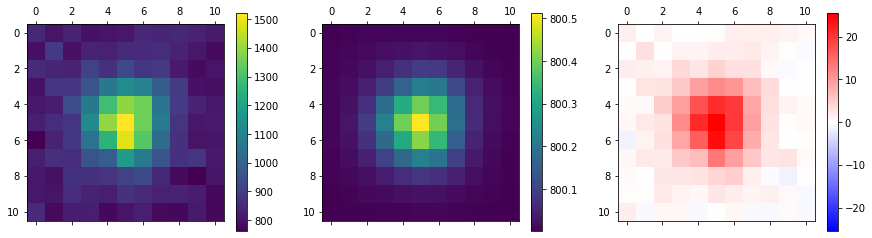

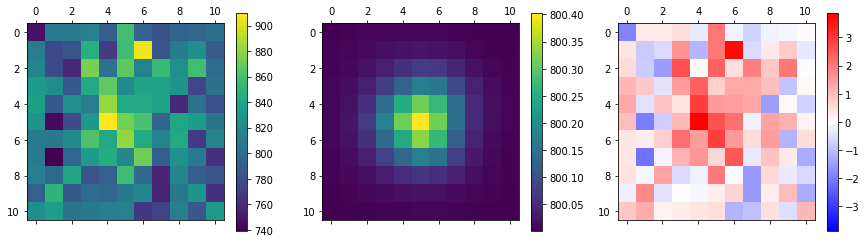

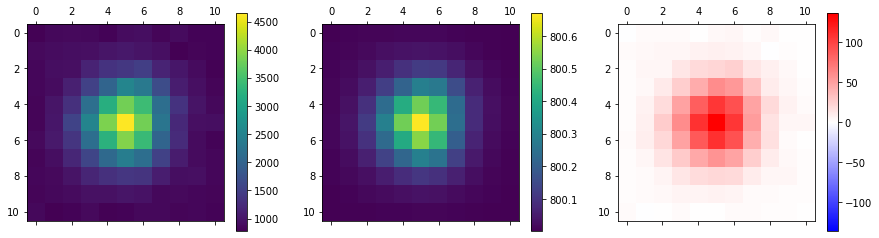

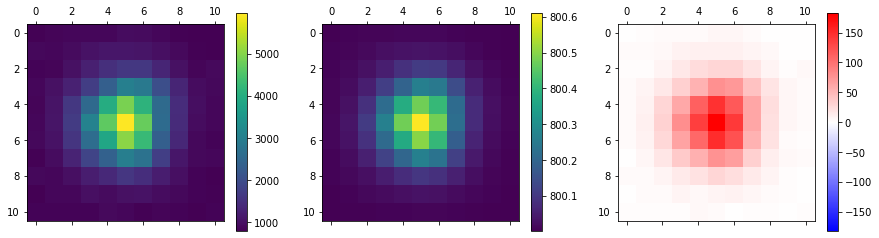

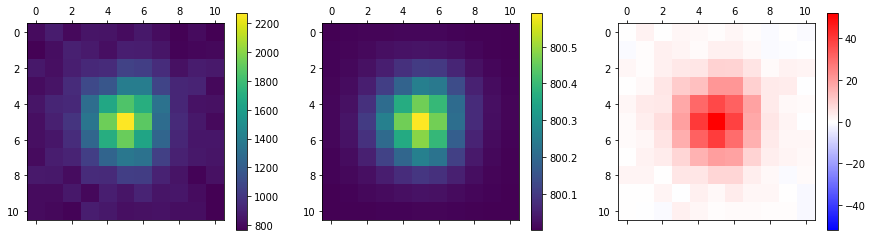

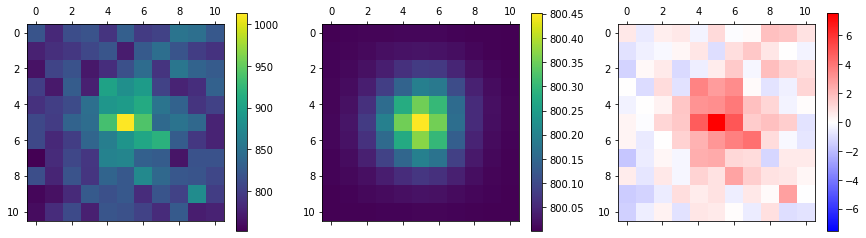

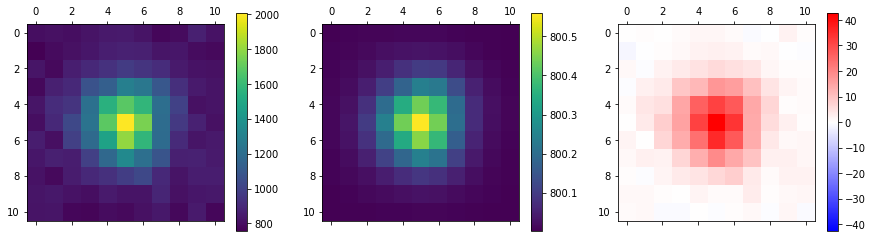

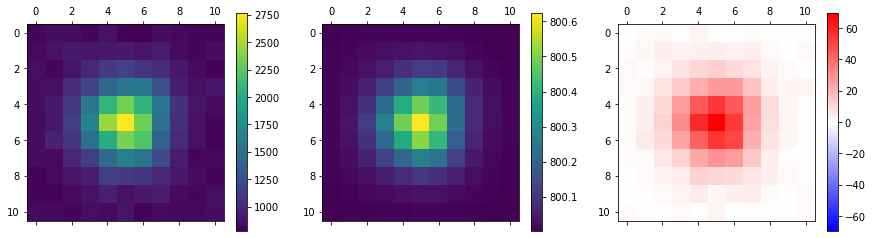

In [20]:
for i in range(10): 
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    image = test_batch['image'][i, 0].cpu()
    
    true_flux = true_fluxes.squeeze()[i]
    est_flux = means.squeeze()[i].detach().cpu()
    
    # plot true image    
    im = ax[0].matshow(image)
    fig.colorbar(im, ax = ax[0])

    # plot reconstructed image 
    recon = reconstruct_image(est_flux).cpu()
    im1 = ax[1].matshow(recon)
    fig.colorbar(im1, ax = ax[1])
    
    # plt residual 
    resid = (image - recon) / torch.sqrt(recon)
    vmax = resid.abs().max()
    im2 = ax[2].matshow(resid, 
                        vmax = vmax, 
                        vmin = -vmax, 
                        cmap = plt.get_cmap('bwr'))
    fig.colorbar(im2, ax = ax[2])